# RL LunarLanding: Actor Critic

In [1]:
import numpy as np
import gym
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import random

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam


Observation space: (8,) n_actions: 4


c:\Users\pierg\Desktop\VirtualEnvironments\Standard_env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Episode 1: Reward = -120.4067341908194, Mean reward = -120.4067341908194
Episode 2: Reward = -99.86557953429742, Mean reward = -120.4067341908194
Episode 3: Reward = -106.3402384006148, Mean reward = -110.13615686255841
Episode 4: Reward = -480.66162338127066, Mean reward = -108.87085070857721
Episode 5: Reward = -128.863147939577, Mean reward = -201.81854387675057
Episode 6: Reward = -135.73790346792657, Mean reward = -187.22746468931587
Episode 7: Reward = -214.47758880767157, Mean reward = -178.64587115241764
Episode 8: Reward = -122.02027121662438, Mean reward = -183.76468796031105
Episode 9: Reward = -122.9173419683244, Mean reward = -176.04663586735023
Episode 10: Reward = -131.1234378409673, Mean reward = -170.14338098968068
Episode 11: Reward = -58.102579820704705, Mean reward = -166.24138667480935
Episode 12: Reward = -32.10873980998386, Mean reward = -156.41058605170892
Episode 13: Reward = -81.54494202408594, Mean reward = -146.0520988648985
Episode 14: Reward = -80.05928806

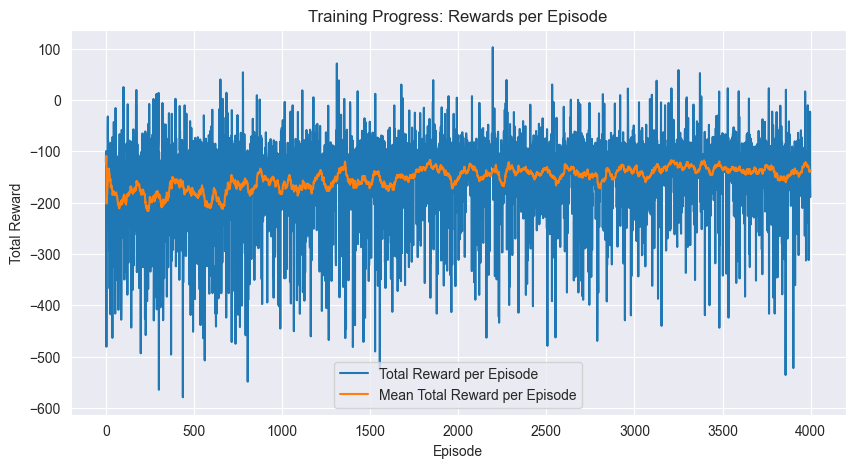

In [8]:
from collections import deque
import time

#---------- Environment and seeds -----------------#

env = gym.make('LunarLander-v2')
input_shape = env.observation_space.shape
n_actions = env.action_space.n
print("Observation space:", input_shape, "n_actions:", n_actions)

tf.keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)
env.action_space.seed(42)  # Ensures deterministic action sampling



#---------- Parameters -----------------#

n_iterations = 4000
gamma = 0.999  # Discount factor
learning_rate_actor = 0.0001
learning_rate_critic = 0.0001
batch_size = 32
tau = 0.01


#---------- Neural nets-----------------#

actor_model = Sequential([
    Dense(32, activation='relu', input_shape=input_shape),
    Dense(32, activation='relu'),
    Dense(n_actions, activation='softmax')                         
])

critic_model = Sequential([
    Dense(32, activation='relu', input_shape=input_shape),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')                       # Single value for teh critic (V-value) which is V(s)            
])

inital_weights_actor = actor_model.get_weights()
inital_weights_critic = critic_model.get_weights()

# Optimizer and loss
optimizer_actor = Adam(learning_rate=learning_rate_actor)
optimizer_critic = Adam(learning_rate=learning_rate_critic)

def actor_loss(advantages, actions, actor_model):
    log_probs = tf.math.log(actor_model)  # Log of the predicted probabilities
    action_log_prob = tf.reduce_sum(log_probs * actions, axis=1)
    return -tf.reduce_mean(action_log_prob * advantages)  # Policy gradient loss (negative for maximization)

def critic_loss(critic_values, rewards, values_next, discount_factor=0.99):
    # TD Error as loss
    td_target = rewards + discount_factor * values_next
    return tf.reduce_mean(tf.square(td_target - critic_values))  # MSE loss for critic




#---------- Neural fast functions-----------------#

@tf.function  
def predict_actorModel_fast(state):
    return actor_model(state, training=False)  

@tf.function  
def predict_criticModel_fast(state):
    return critic_model(state, training=False)  


#---------- Play Episodes functions -----------------#



# Function to take a step and store transition
def actor_critic_step(state):
    #state = np.expand_dims(state, axis=0)
    #action_probs = actor_model(state)
    action_probs = predict_actorModel_fast(state[np.newaxis])
    action = np.random.choice(n_actions, p=action_probs.numpy()[0])  # Sample action
    return action

# Select action using the policy
def choose_action(state, actor_model):
    #state = np.expand_dims(state, axis=0)
    #probs = actor_model.predict(state, verbose=0)[0]
    probs = predict_actorModel_fast(state[np.newaxis])
    action = np.random.choice(n_actions, p=probs.numpy()[0])
    return action


#---------- Normalization and discount of the rewards -----------------#

def compute_returns(rewards, dones, next_state, critic_model):
    returns = []
    #R = critic_model.predict(np.expand_dims(next_state, axis=0), verbose=0)[0, 0]
    R = predict_criticModel_fast(next_state[np.newaxis])[0, 0]
    for reward, done in zip(reversed(rewards), reversed(dones)):
        R = reward + (1 - done) * gamma * R
        returns.insert(0, R)
    return np.array(returns)



#---------- Gradient related functions (training) -----------------#
@tf.function
def apply_gradients(optimizer_actor, optimizer_critic, actor_model, critic_model, actor_grads, critic_grads):
    optimizer_actor.apply_gradients(zip(actor_grads, actor_model.trainable_variables))
    optimizer_critic.apply_gradients(zip(critic_grads, critic_model.trainable_variables))

def train(actor_model, critic_model, optimizer_actor, optimizer_critic, states, actions, returns):
    with tf.GradientTape() as tape_actor, tf.GradientTape() as tape_critic:
        states = np.array(states)
        actions = np.array(actions)
        
        # Compute values and advantages
        #values = predict_criticModel_fast(states)
        values = critic_model(states)
        advantages = returns - tf.squeeze(values)

        # Actor loss (policy gradient)
        #action_probs = predict_actorModel_fast(states)
        action_probs = actor_model(states)
        action_masks = tf.one_hot(actions, n_actions)
        log_probs = tf.reduce_sum(action_masks * tf.math.log(action_probs + 1e-8), axis=1)
        actor_loss = -tf.reduce_mean(log_probs * advantages)

        # Critic loss (MSE)
        critic_loss = tf.reduce_mean(tf.square(returns - values))

    # Compute gradients and update models
    actor_grads = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
    critic_grads = tape_critic.gradient(critic_loss, critic_model.trainable_variables)
    apply_gradients(optimizer_actor, optimizer_critic, actor_model, critic_model, actor_grads, critic_grads)
    

def soft_update_weights(model, tau=tau):
    # Perform a soft update on the weights
    current_weights = model.get_weights()
    updated_weights = model.get_weights()  # Get new weights after applying gradients

    # Soft update rule
    new_weights = [tau * updated + (1 - tau) * current for updated, current in zip(updated_weights, current_weights)]
    
    model.set_weights(new_weights)  # Update the model with blended weights



    




#---------- Training -----------------#

env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

total_rewards_list = []
mean_rewards_list = []
best_score = 0
total_rewards = 0

actor_model.set_weights(inital_weights_actor)
critic_model.set_weights(inital_weights_critic)

start_time = time.time()

for episode in range(n_iterations):
    state = env.reset()
    done = False
    total_reward = 0
    states, actions, rewards, dones = [], [], [], []

    while not done:
        action = choose_action(state, actor_model)
        next_state, reward, done, _ = env.step(action)

        # Store experience
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        dones.append(done)

        state = next_state
        total_reward += reward

    # Compute returns and train models
    total_rewards += total_reward
    m_r = np.mean(total_rewards_list[-50:]) if total_rewards_list else total_reward
    mean_rewards_list.append(m_r)
    total_rewards_list.append(total_reward)

    if mean_rewards_list[-1] > best_score:
        best_weights_actor = actor_model.get_weights()
        best_weights_critic = critic_model.get_weights()
        best_score = mean_rewards_list[-1]

    returns = compute_returns(rewards, dones, next_state, critic_model)
    train(actor_model, critic_model, optimizer_actor, optimizer_critic, states, actions, returns)

    print(f"Episode {episode + 1}: Reward = {total_reward}, Mean reward = {m_r}")

env.close()

actor_model.set_weights(best_weights_actor)
critic_model.set_weights(best_weights_critic)
end_time = time.time()
print(f"Training took {end_time - start_time:.2f} seconds")

# Use Seaborn to plot rewards per episode
sns.set_style("darkgrid")  # Set a nice style
plt.figure(figsize=(10, 5))  # Set figure size

sns.lineplot(x=range(len(total_rewards_list)), y=total_rewards_list, label="Total Reward per Episode")
sns.lineplot(x=range(len(mean_rewards_list)), y=mean_rewards_list, label="Mean Total Reward per Episode")

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Progress: Rewards per Episode")
plt.legend()
plt.show()



In [7]:
# For plotting the animated video
import matplotlib.animation as animation
import matplotlib as mpl
mpl.rc('animation', html='jshtml')


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim


state = env.reset()
random.seed(None)  # Reset to default, random state
np.random.seed(None)
tf.random.set_seed(None)


frames = []
total_reward = 0
average_reward = 0
total_rewards = 0
n_max_steps = 1000
# Interact with the environment using the trained model
for i in range(30):
    total_reward = 0
    obs = env.reset()
    for step in range(n_max_steps):
        # Get action probabilities from the model
        action = choose_action(state=obs, actor_model=actor_model)
        obs, reward, done, info = env.step(action)
        total_reward += reward
    
        if done:
            break
        frames.append(env.render(mode="rgb_array"))  # Collect frames for animation
    total_rewards += total_reward
    average_reward = total_rewards / (i+ 1)
    print(f"Episode: {i+1}, Total Reward:{total_reward}, Mean Reward: {average_reward}")
    #plot_animation(frames)

# Close the environment
#env.close()





Episode: 1, Total Reward:-27.25260503948283, Mean Reward: -27.25260503948283
Episode: 2, Total Reward:-13.713731248970422, Mean Reward: -20.483168144226624
Episode: 3, Total Reward:16.556654758733053, Mean Reward: -8.136560509906731
Episode: 4, Total Reward:0.4882093014597899, Mean Reward: -5.980368057065101
Episode: 5, Total Reward:25.449626926008964, Mean Reward: 0.30563093954971166
Episode: 6, Total Reward:49.224596086349834, Mean Reward: 8.458791797349733
Episode: 7, Total Reward:24.8559362985754, Mean Reward: 10.801241011810543
Episode: 8, Total Reward:30.997239202869196, Mean Reward: 13.325740785692874
Episode: 9, Total Reward:81.22633642974034, Mean Reward: 20.870251412809257
Episode: 10, Total Reward:30.254622411652093, Mean Reward: 21.808688512693543
Episode: 11, Total Reward:3.7315598002833923, Mean Reward: 20.16531317520171
Episode: 12, Total Reward:51.497478084750895, Mean Reward: 22.776326917664147
Episode: 13, Total Reward:-5.7827538068771105, Mean Reward: 20.579474554237